In [2]:
import os
os.system("git clone https://github.com/soerenetler/squad-question-generation.git")
os.system("git clone https://github.com/soerenetler/spacy_target_answer.git")
os.system("git clone https://github.com/soerenetler/crf_target_answer.git")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!(cd squad-question-generation/; git pull)
!(cd crf_target_answer/; git pull)

Already up to date.
Already up to date.


In [15]:
!cp crf_target_answer/Custom.py Custom.py
!cp crf_target_answer/FeatureTransformer.py FeatureTransformer.py
!cp crf_target_answer/model/evaluation_utils.py evaluation_utils.py

In [5]:
!pip install -r crf_target_answer/requirements.txt --quiet

     |████████████████████████████████| 112kB 5.1MB/s 
     |████████████████████████████████| 747kB 6.8MB/s 


In [9]:
!pip install allennlp allennlp-models -U --quiet

     |████████████████████████████████| 604kB 5.3MB/s 
     |████████████████████████████████| 419kB 10.5MB/s 
     |████████████████████████████████| 122kB 16.4MB/s 
     |████████████████████████████████| 2.1MB 16.5MB/s 
     |████████████████████████████████| 133kB 43.9MB/s 
     |████████████████████████████████| 1.2MB 39.4MB/s 
     |████████████████████████████████| 266kB 48.1MB/s 
     |████████████████████████████████| 2.0MB 44.8MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 133kB 46.1MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 163kB 51.7MB/s 
     |████████████████████████████████| 7.4MB 41.1MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 870kB 51.6MB/s 
     |████████████████████████████████| 3.3MB 46.9MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
E

In [10]:
!pip install --quiet -U pip setuptools wheel

     |████████████████████████████████| 1.5MB 5.0MB/s 
     |████████████████████████████████| 788kB 32.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [11]:
!pip install --quiet -U spacy[cuda110,transformers,lookups]

     |████████████████████████████████| 12.8 MB 6.3 MB/s 
     |████████████████████████████████| 9.1 MB 62.4 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 456 kB 50.4 MB/s 
     |████████████████████████████████| 93.4 MB 39 kB/s 
     |████████████████████████████████| 165.3 MB 41 kB/s 
     |████████████████████████████████| 113 kB 57.0 MB/s 
     |████████████████████████████████| 1.8 MB 53.5 MB/s 
     |████████████████████████████████| 66 kB 4.0 MB/s 
     |████████████████████████████████| 998 kB 56.6 MB/s 
     |████████████████████████████████| 2.9 MB 50.5 MB/s 


In [12]:
!python -m spacy download en_core_web_sm --quiet
!python -m spacy download en_core_web_trf --quiet

2021-04-12 06:48:00.407327: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7 MB 121 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-04-12 06:48:11.692987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 459.7 MB 14 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [13]:
!spacy validate

2021-04-12 06:48:54.706352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.5) =================
ℹ spaCy installation: /usr/local/lib/python3.7/dist-packages/spacy

NAME              SPACY            VERSION                            
en_core_web_sm    >=3.0.0,<3.1.0   3.0.0   ✔
en_core_web_trf   >=3.0.0,<3.1.0   3.0.0   ✔



In [16]:
import joblib
import eli5
import pandas as pd
from FeatureTransformer import FeatureTransformer
import pandas as pd
import ast
import spacy
from Custom import *
from sklearn_crfsuite import metrics
from evaluation_utils import visualize_transitions, print_annotated_text, crf_roc_curve

In [19]:
be = joblib.load('/content/gdrive/MyDrive/mt-qg-data/00_models/crf_target_answer/squad/10000/best_estimator.pkl')

In [21]:
import json

data_folder = "/content/gdrive/MyDrive/mt-qg-data/01_data/preprocessedData/"
dataset = "squad"
NO_SAMPLES = 10000

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_train_crf.txt') as f:
  data_json = json.load(f)
  train_feature = data_json["x"]
  y_train = data_json["y"]

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_test_crf.txt') as f:
  data_json = json.load(f)
  test_feature = data_json["x"]
  y_test = data_json["y"]

10000it [01:27, 113.72it/s]
10000it [01:43, 96.80it/s]
23793it [05:27, 72.72it/s] 


In [22]:
y_pred_test = be.predict(test_feature)
y_pred_test_marginals = be.predict_proba(test_feature)

y_pred_train = be.predict(train_feature)
y_pred_train_marginals = be.predict_proba(train_feature)

              precision    recall  f1-score   support

    B-Answer    0.00000   0.00000   0.00000      2592
    I-Answer    0.00000   0.00000   0.00000      9152
           O    0.79431   0.99996   0.88535     45353

    accuracy                        0.79428     57097
   macro avg    0.26477   0.33332   0.29512     57097
weighted avg    0.63093   0.79428   0.70324     57097



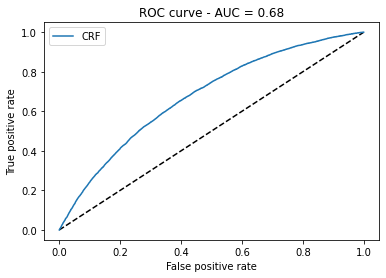

In [23]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(io2iob(y_test), y_pred_test, digits=5))
crf_roc_curve(io2iob(y_test), y_pred_test_marginals)

             precision    recall  f1-score   support

   I-Answer    0.59903   0.01288   0.02522     38500
          O    0.85593   0.99853   0.92175    226109

avg / total    0.81855   0.85512   0.79130    264609



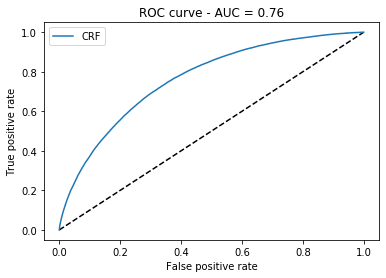

In [ ]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(y_train, y_pred_train, digits=5))
crf_roc_curve(y_train, y_pred_train_marginals)

In [25]:
eli5.show_weights(be, top=50)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## .......

In [ ]:
# Print one example output
paragraph = nlp("A Japan-exclusive manga series based on Twilight Princess, penned and illustrated by Akira Himekawa, was first released on February 8, 2016. The series is available solely via publisher Shogakukan's MangaOne mobile application. While the manga adaptation began almost ten years after the initial release of the game on which it is based, it launched only a month before the release of the high-definition remake.")
y_true = ['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

tokens =[token.text for token in paragraph]
y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))
print_annotated_text(tokens, y_pred, y_trues=y_true)

IndexError: list index out of range

In [ ]:
# Print 100 randomly sampled text
from IPython.display import Latex
for index, row in df_askable_paragraph_test.iterrows(): #.sample(n=100, random_state=1)
    if nlp(row["paragraph_context"])[:3].text == "The Norman dynasty":
        paragraph = nlp(row["paragraph_context"])
        y_true = row["askable_tokens"]
        tokens =[token.text for token in paragraph]
        y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))

        print_annotated_text(tokens, y_pred, y_trues=y_true)
        Latex(print_annotated_text_latex(tokens, y_pred, y_trues=y_true))